## Getting Data from Yahoo! Finance with pandas

In [1]:
import pandas as pd
import pandas_datareader as pdr
import datetime

In [2]:
start = datetime.datetime(2017,1,1)
end = datetime.date.today()

apple = pdr.get_data_yahoo('AAPL', start, end)

In [3]:
type(apple)

pandas.core.frame.DataFrame

In [4]:
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,115.800003,116.330002,114.760002,116.150002,114.722694,28781900
2017-01-04,115.849998,116.510002,115.750000,116.019997,114.594292,21118100
2017-01-05,115.919998,116.860001,115.809998,116.610001,115.177040,22193600
2017-01-06,116.779999,118.160004,116.470001,117.910004,116.461075,31751900
2017-01-09,117.949997,119.430000,117.940002,118.989998,117.527794,33387600


## Visualizing Stock Data

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


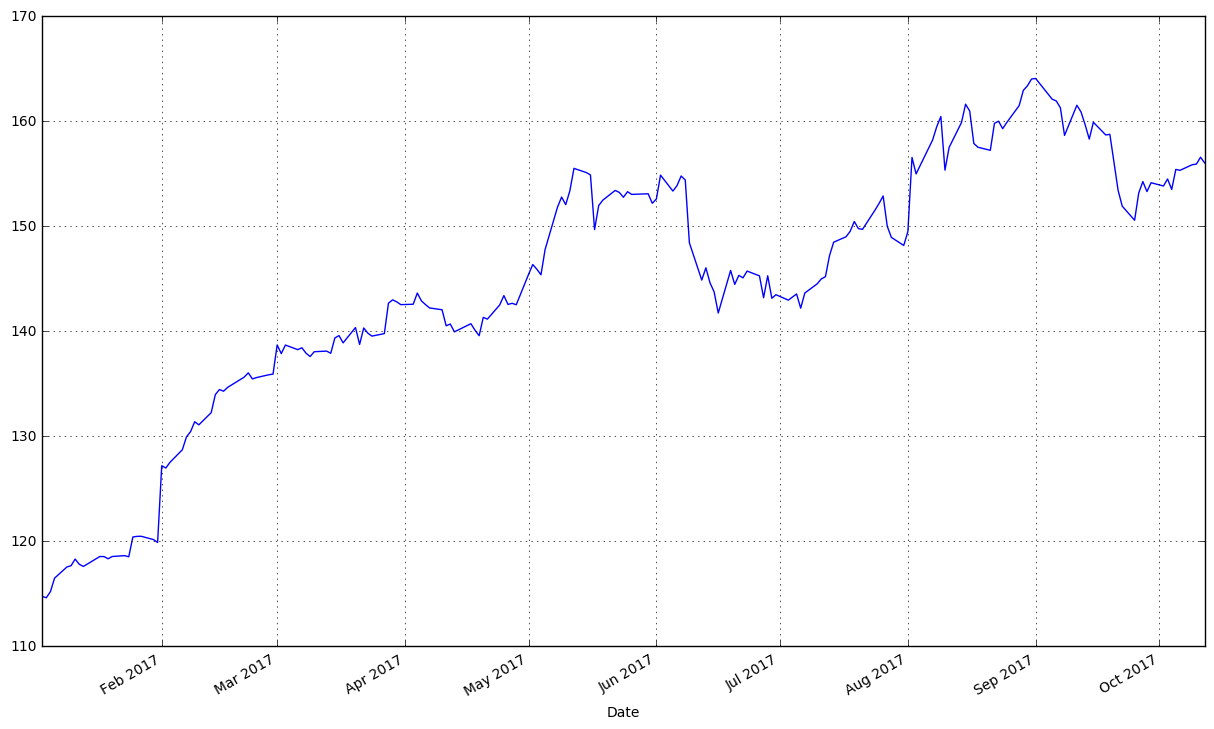

In [6]:
pylab.rcParams['figure.figsize'] = (15, 9)
apple["Adj Close"].plot(grid = True)

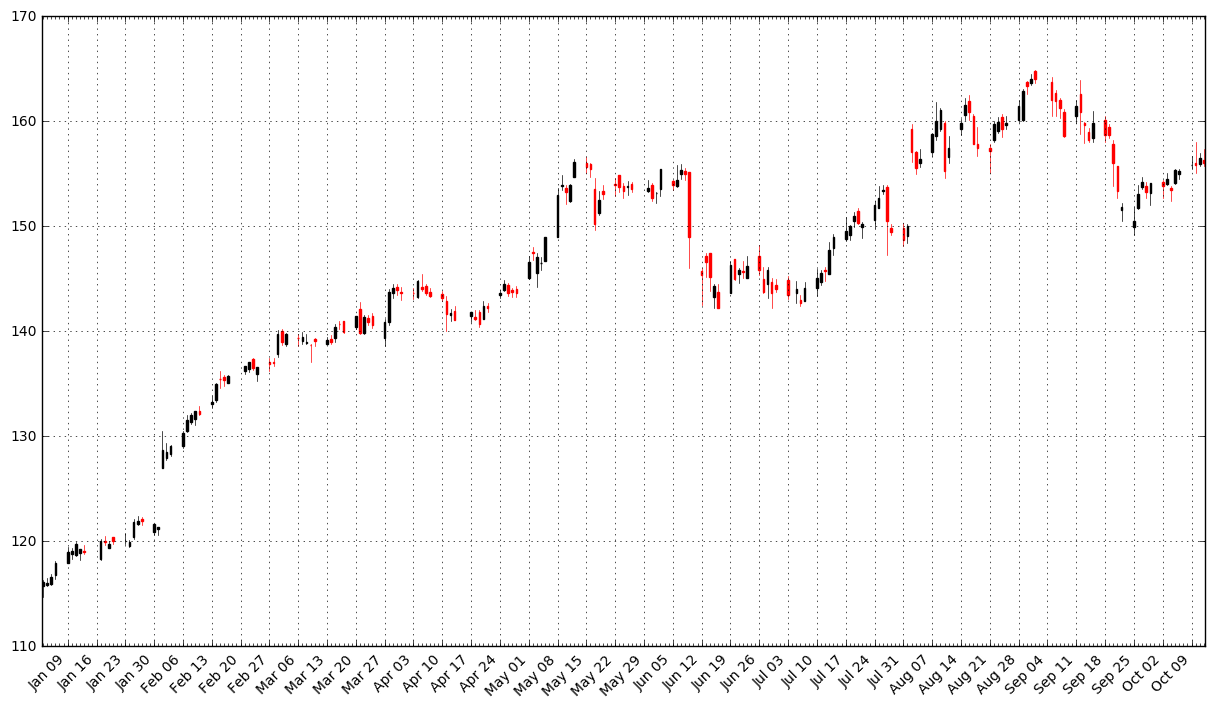

In [7]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple)

## Compare Multiple Stocks

In [8]:
microsoft = pdr.get_data_yahoo('MSFT', start, end)
google = pdr.get_data_yahoo('GOOG', start, end)
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})
 
stocks.head()

,AAPL,GOOG,MSFT
Date,,,
2017-01-03,114.722694,786.140015,61.520611
2017-01-04,114.594292,786.900024,61.245350
2017-01-05,115.177040,794.020020,61.245350
2017-01-06,116.461075,806.150024,61.776207
2017-01-09,117.527794,806.650024,61.579594


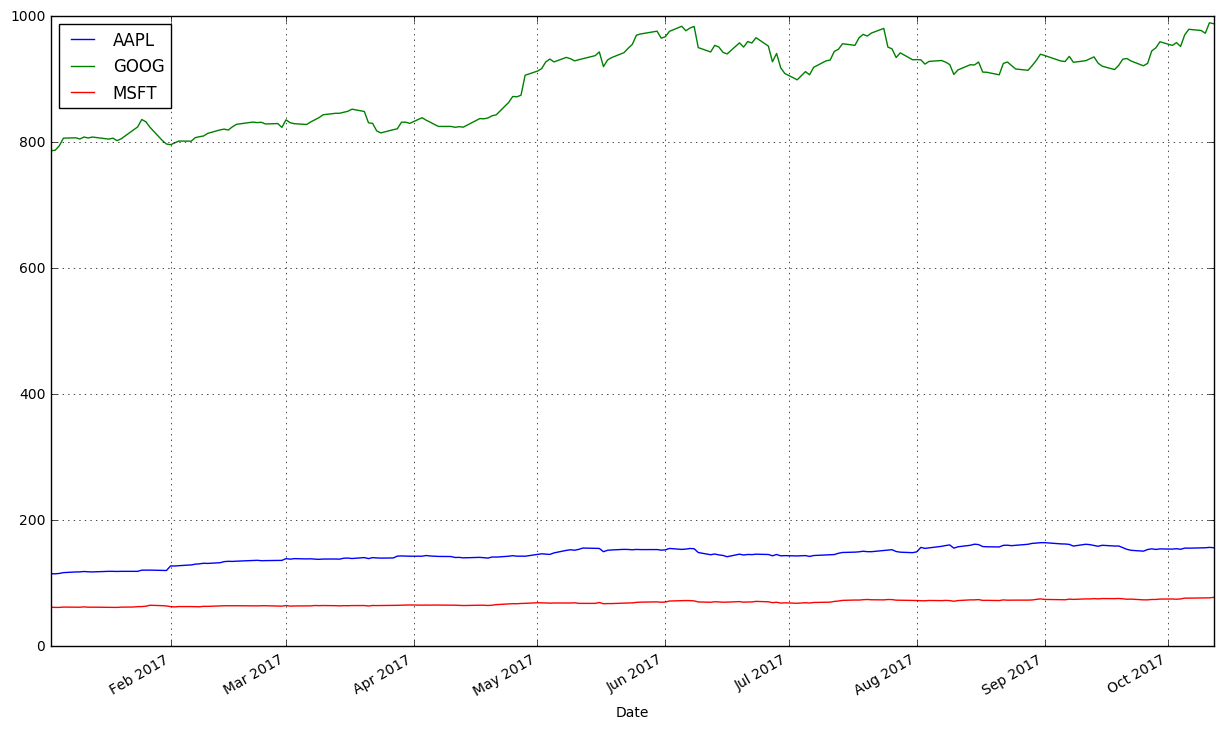

In [9]:
stocks.plot(grid = True)

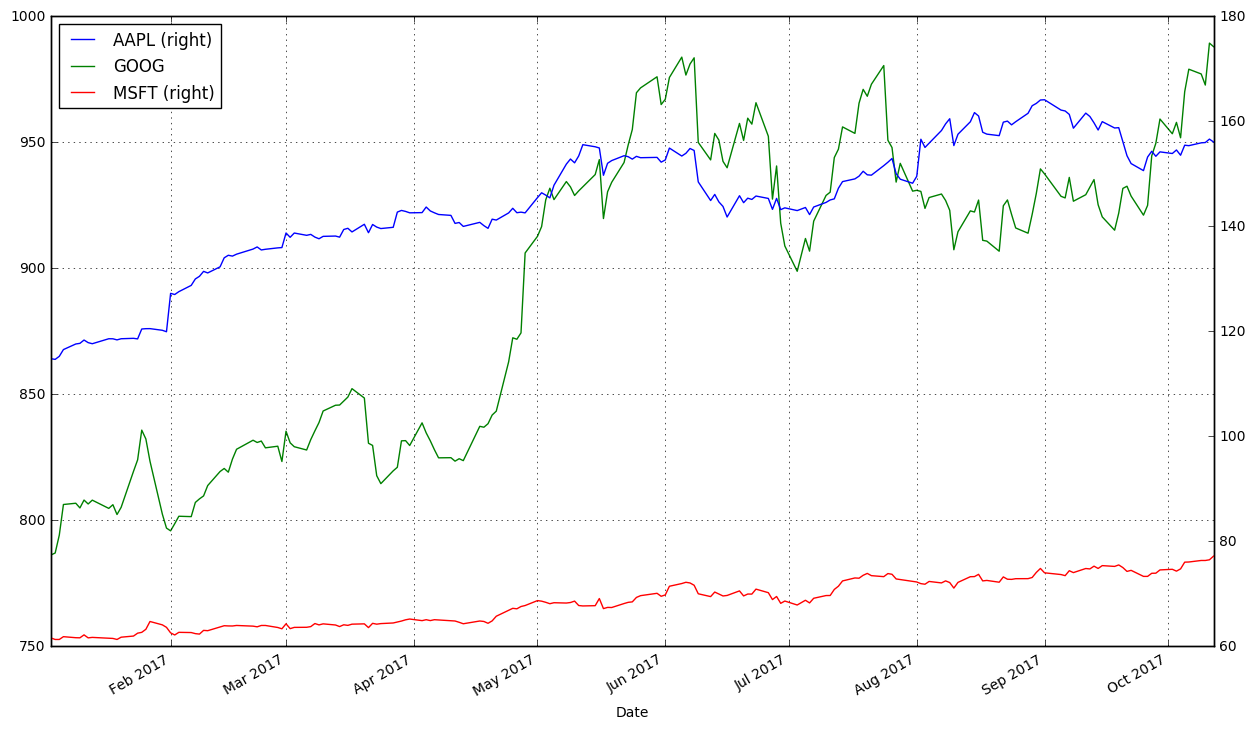

In [10]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

In [11]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

,AAPL,GOOG,MSFT
Date,,,
2017-01-03,1.000000,1.000000,1.000000
2017-01-04,0.998881,1.000967,0.995526
2017-01-05,1.003960,1.010024,0.995526
2017-01-06,1.015153,1.025453,1.004155
2017-01-09,1.024451,1.026090,1.000959


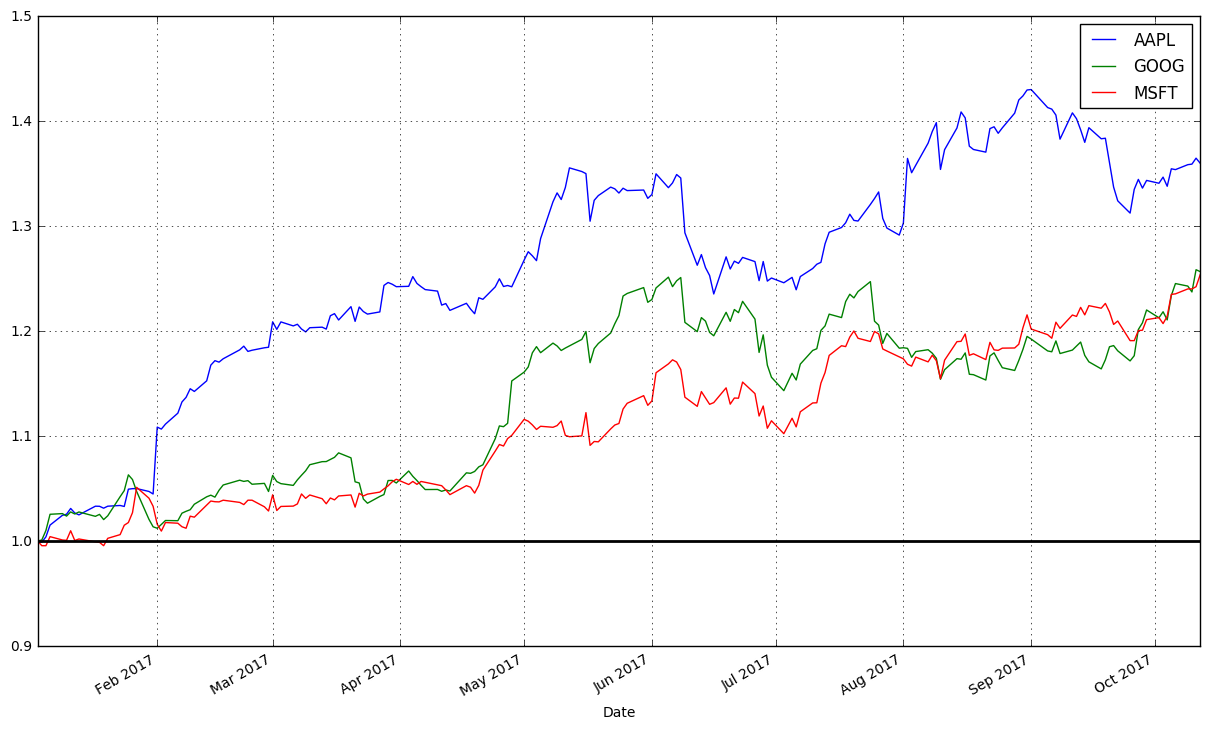

In [12]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

## Moving Average

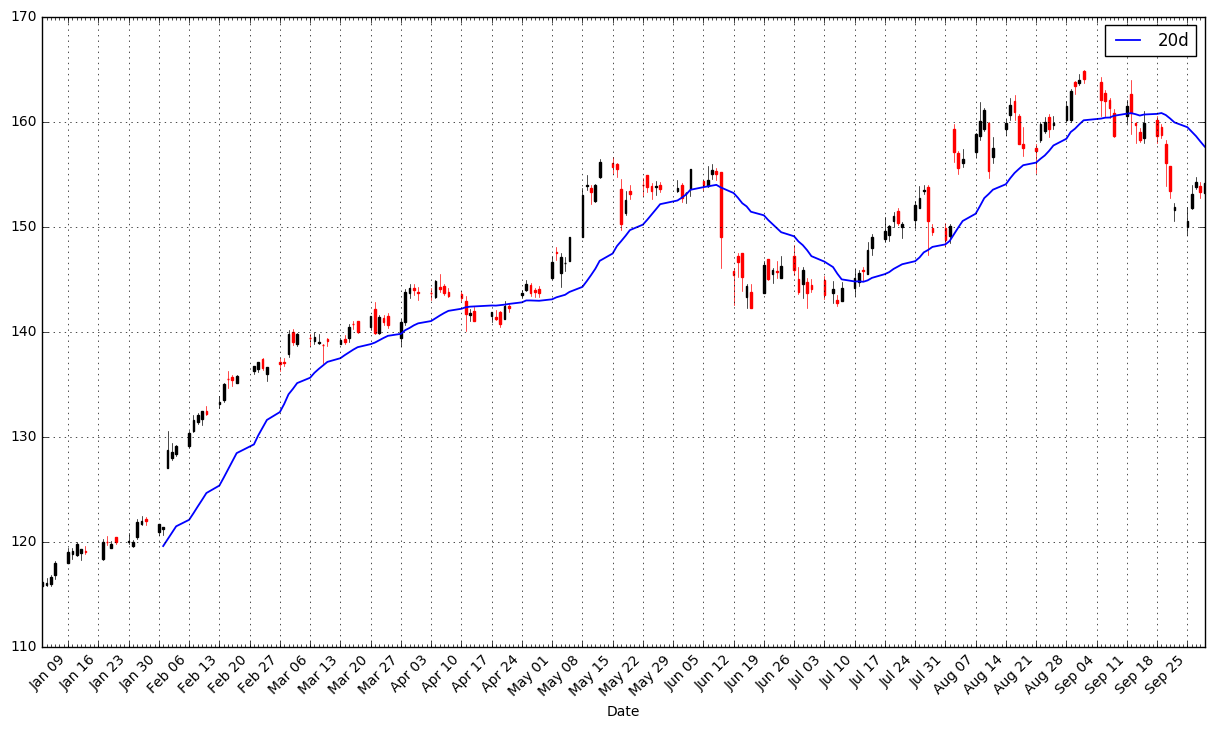

In [13]:
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(apple.loc['2017-01-01':'2017-10-01',:], otherseries = "20d")

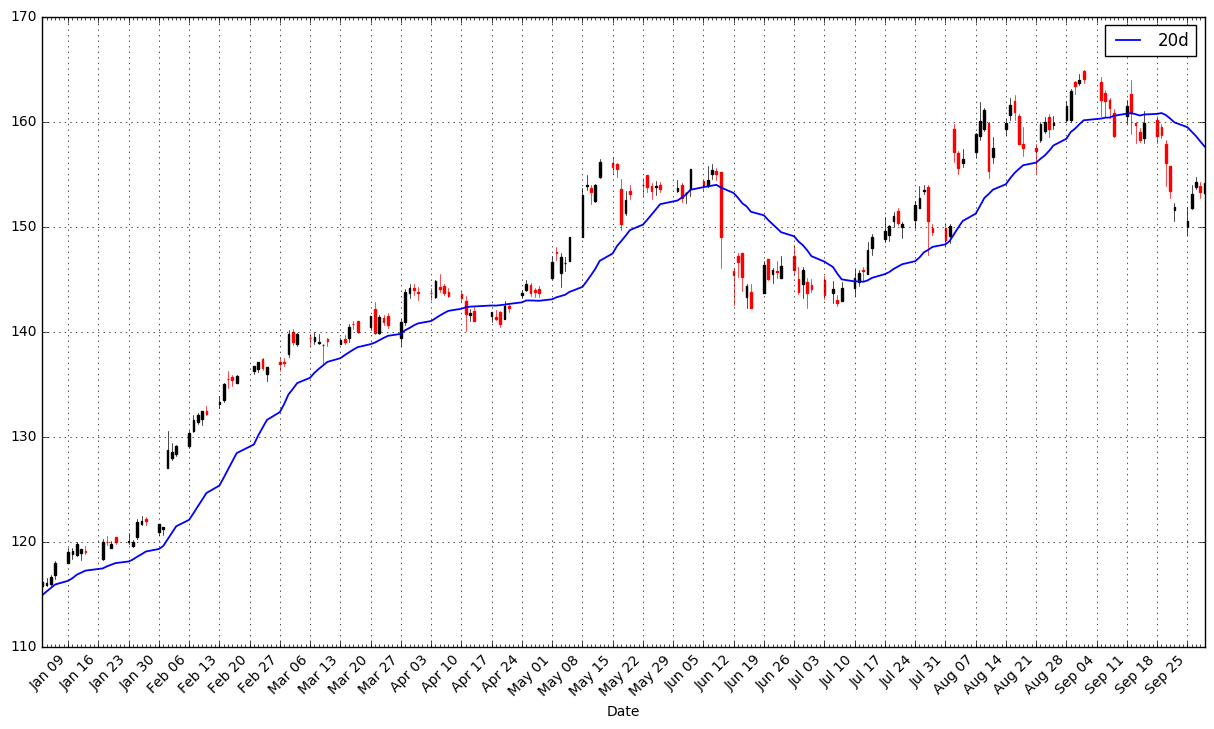

In [14]:
## fillup the gap at the beginning, load data of previous year to calculate the MA

start = datetime.datetime(2014,1,1)
apple = pdr.get_data_yahoo("AAPL", start, end)
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2017-01-01':'2017-10-01',:], otherseries = "20d")

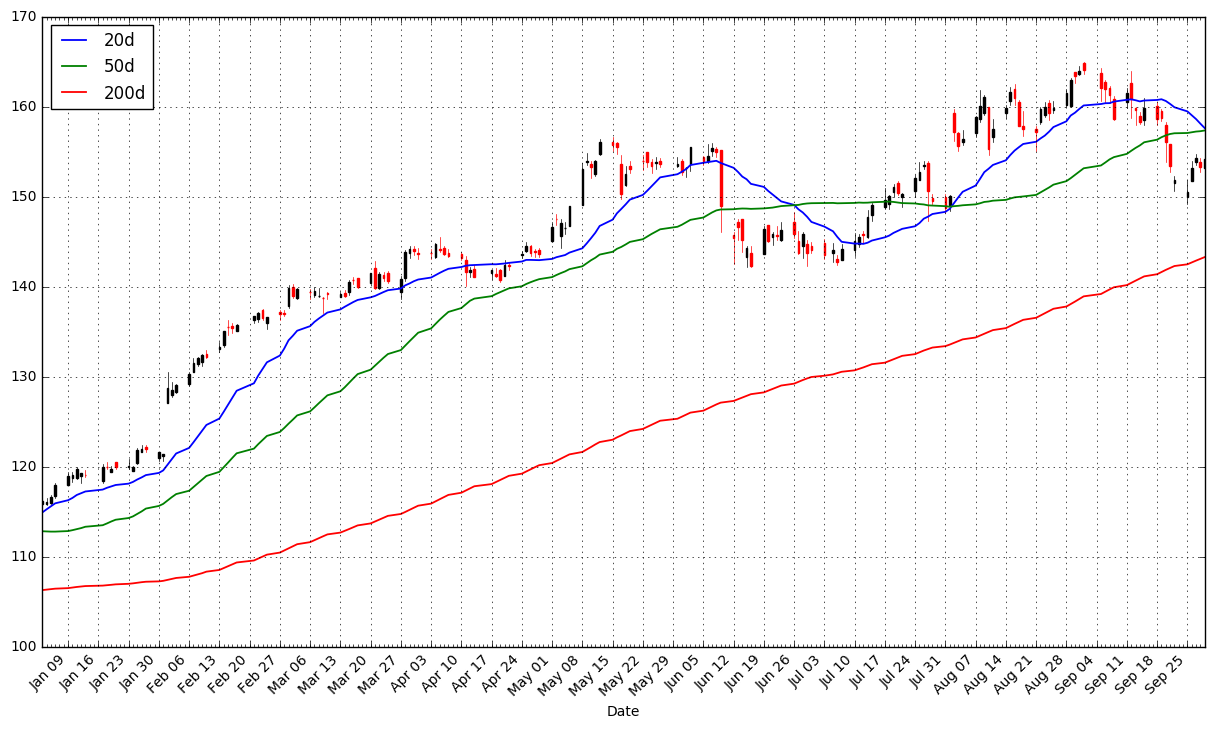

In [15]:
apple["50d"] = np.round(apple["Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2017-01-01':'2017-10-01',:], otherseries = ["20d", "50d", "200d"])

## Trading Strategy

    moving average crossover strategy
http://www.investopedia.com/university/movingaverage/movingaverages4.asp

In [16]:

apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

,Open,High,Low,Close,Adj Close,Volume,20d,50d,200d,20d-50d
Date,,,,,,,,,,
2017-10-06,154.970001,155.490005,154.559998,155.300003,155.300003,17407600,155.83,157.61,144.23,-1.78
2017-10-09,155.809998,156.729996,155.490005,155.839996,155.839996,16262900,155.55,157.73,144.43,-2.18
2017-10-10,156.059998,158.000000,155.100006,155.899994,155.899994,15617000,155.30,157.88,144.63,-2.58
2017-10-11,155.970001,156.979996,155.750000,156.550003,156.550003,16905600,155.15,158.01,144.83,-2.86
2017-10-12,156.350006,157.369995,155.729996,156.000000,156.000000,16096600,155.03,157.98,145.02,-2.95


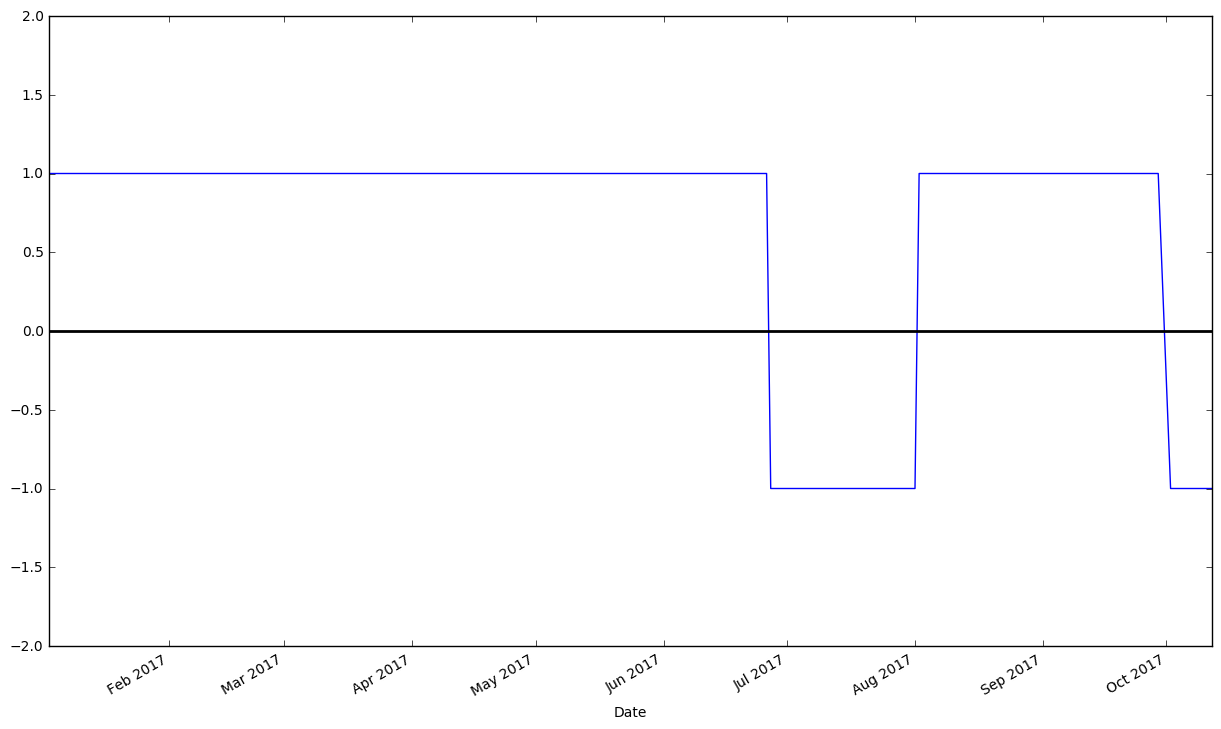

In [25]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc['2017-01-01':'2017-10-12',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

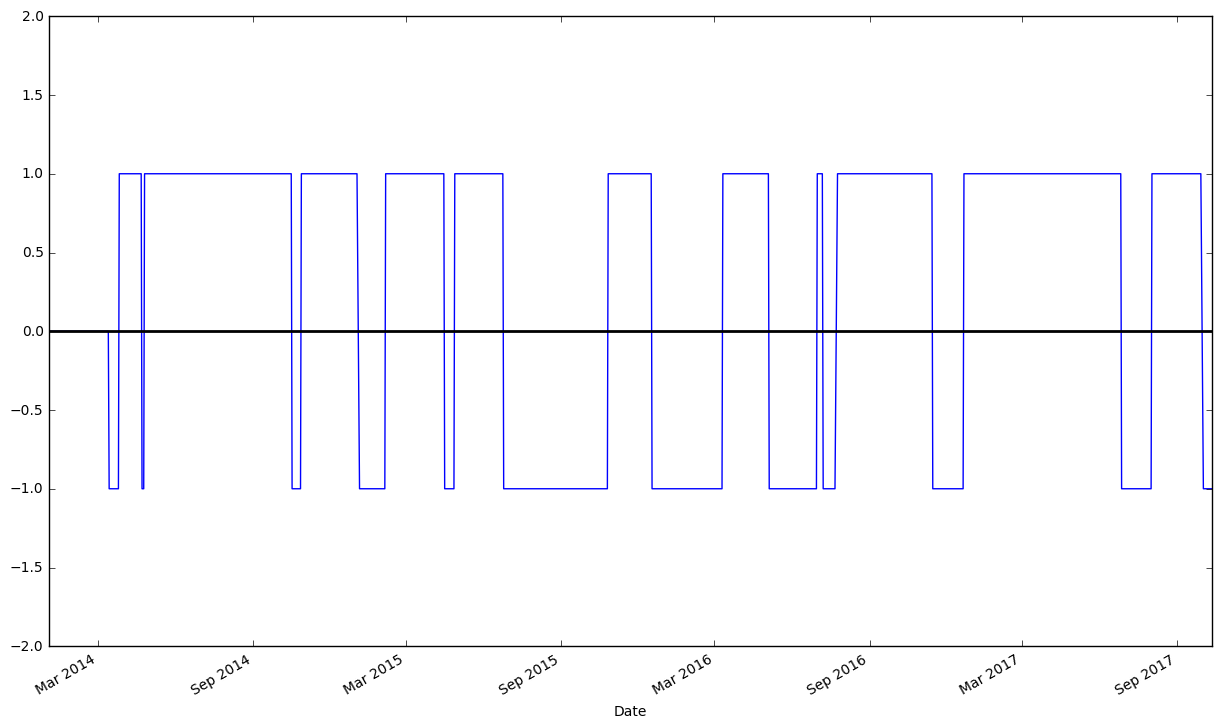

In [18]:
apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [19]:
apple["Regime"].value_counts()

 1    603
-1    301
 0     49
Name: Regime, dtype: int64

In [33]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.ix[-1, "Regime"]
apple.ix[-1, "Regime"] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data if nesessary
# for this example the last regime is -1, already closed out the trades
#apple.ix[-1, "Regime"] = regime_orig
apple.tail()

,Open,High,Low,Close,Adj Close,Volume,20d,50d,200d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,
2017-10-06,154.970001,155.490005,154.559998,155.300003,155.300003,17407600,155.83,157.61,144.23,-1.78,-1,0.0
2017-10-09,155.809998,156.729996,155.490005,155.839996,155.839996,16262900,155.55,157.73,144.43,-2.18,-1,0.0
2017-10-10,156.059998,158.000000,155.100006,155.899994,155.899994,15617000,155.30,157.88,144.63,-2.58,-1,0.0
2017-10-11,155.970001,156.979996,155.750000,156.550003,156.550003,16905600,155.15,158.01,144.83,-2.86,-1,0.0
2017-10-12,156.350006,157.369995,155.729996,156.000000,156.000000,16096600,155.03,157.98,145.02,-2.95,0,1.0


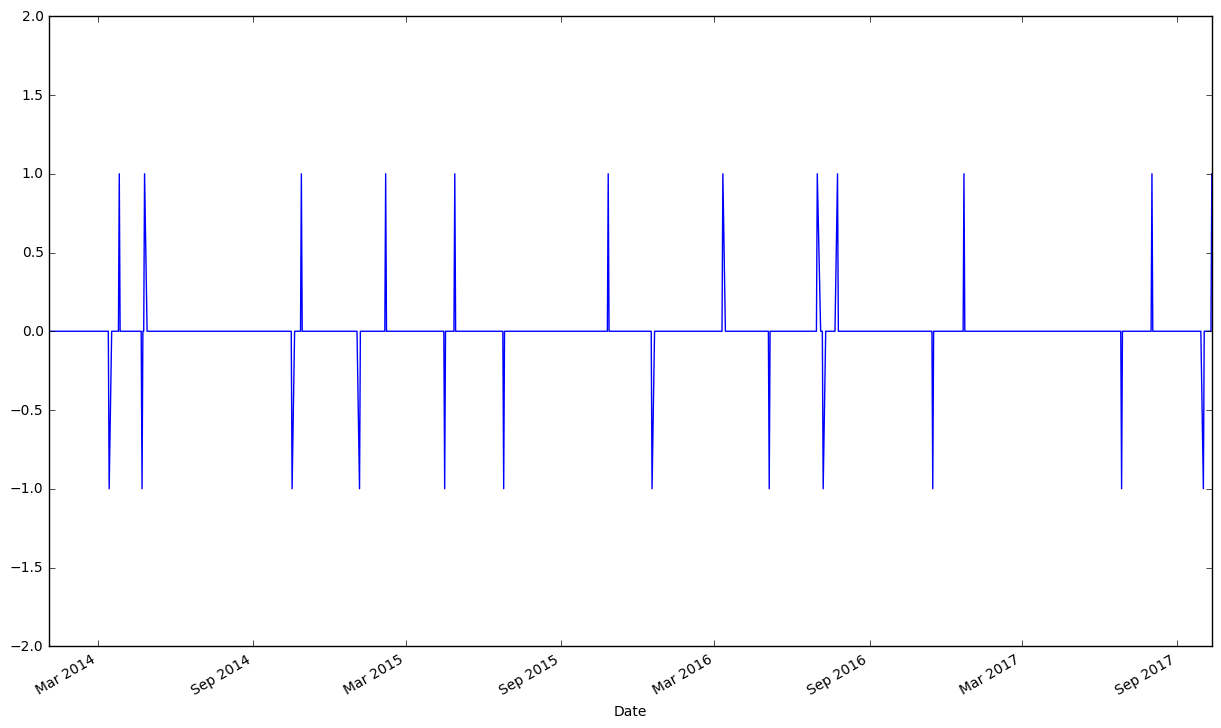

In [21]:
apple["Signal"].plot(ylim = (-2, 2))

In [22]:
apple["Signal"].value_counts()

 0.0    928
-1.0     12
 1.0     12
Name: Signal, dtype: int64

In [34]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2014-03-14,74.955711,-1,Sell
2014-03-26,77.111427,1,Buy
2014-04-22,75.957146,-1,Sell
2014-04-25,81.705711,1,Buy
2014-10-17,97.669998,-1,Sell
2014-10-28,106.739998,1,Buy
2015-01-05,106.250000,-1,Sell
2015-02-05,119.940002,1,Buy
2015-04-16,126.169998,-1,Sell


In [35]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

,End Date,Price,Profit
Date,,,
2014-03-26,2014-04-22,77.111427,-1.154281
2014-04-25,2014-10-17,81.705711,15.964287
2014-10-28,2015-01-05,106.739998,-0.489998
2015-02-05,2015-04-16,119.940002,6.229996
2015-04-28,2015-06-25,130.559998,-3.059998
2015-10-27,2015-12-18,114.550003,-8.520004
2016-03-11,2016-05-05,102.260002,-9.020004
2016-07-01,2016-07-08,95.889999,0.790001
2016-07-25,2016-11-15,97.339996,9.770005


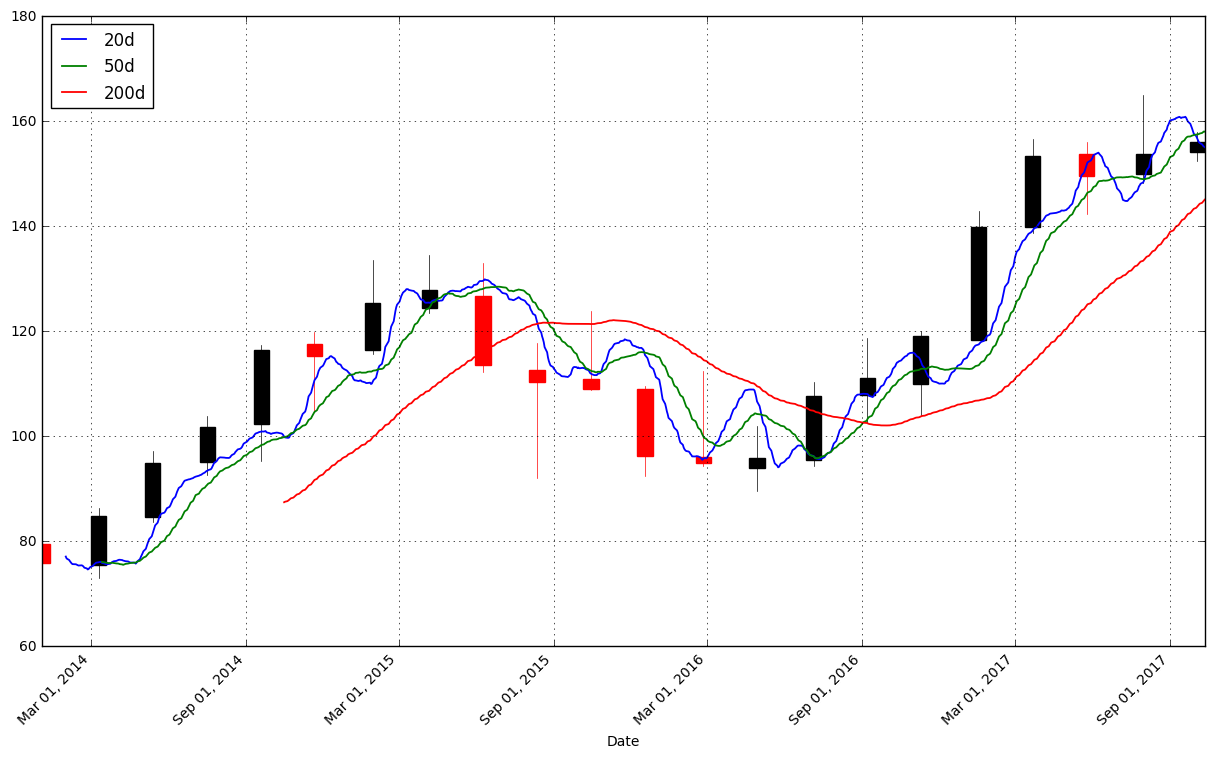

In [36]:
# Let's see the result over the whole period for which we have Apple data
pandas_candlestick_ohlc(apple, stick = 45, otherseries = ["20d", "50d", "200d"])

In [43]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_adj_long_profits.index,
                            "End": apple_adj_long_profits["End Date"]})
apple_adj_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple_adj.loc[x["Start"]:x["End"], "Low"]), axis = 1)
apple_adj_long_profits

,End Date,Price,Profit,Low
Date,,,,
2014-03-14,2014-03-17,70.159729,0.274132,69.933752
2014-03-24,2014-04-22,72.098618,-1.001534,68.373269
2014-04-25,2014-10-17,76.477829,15.910706,75.410772
2014-10-28,2015-01-05,100.968079,-0.027687,99.653243
2015-02-05,2015-04-16,114.395966,5.942024,112.955754
2015-04-28,2015-06-25,124.525078,-2.410607,117.657874
2015-10-27,2015-12-18,110.208076,-7.760406,102.235102
2016-03-10,2016-05-05,98.282295,-7.152160,89.762635
2016-06-23,2016-06-27,93.925415,-3.968124,89.429509


## Adjust Stock Price for Split, Dividends

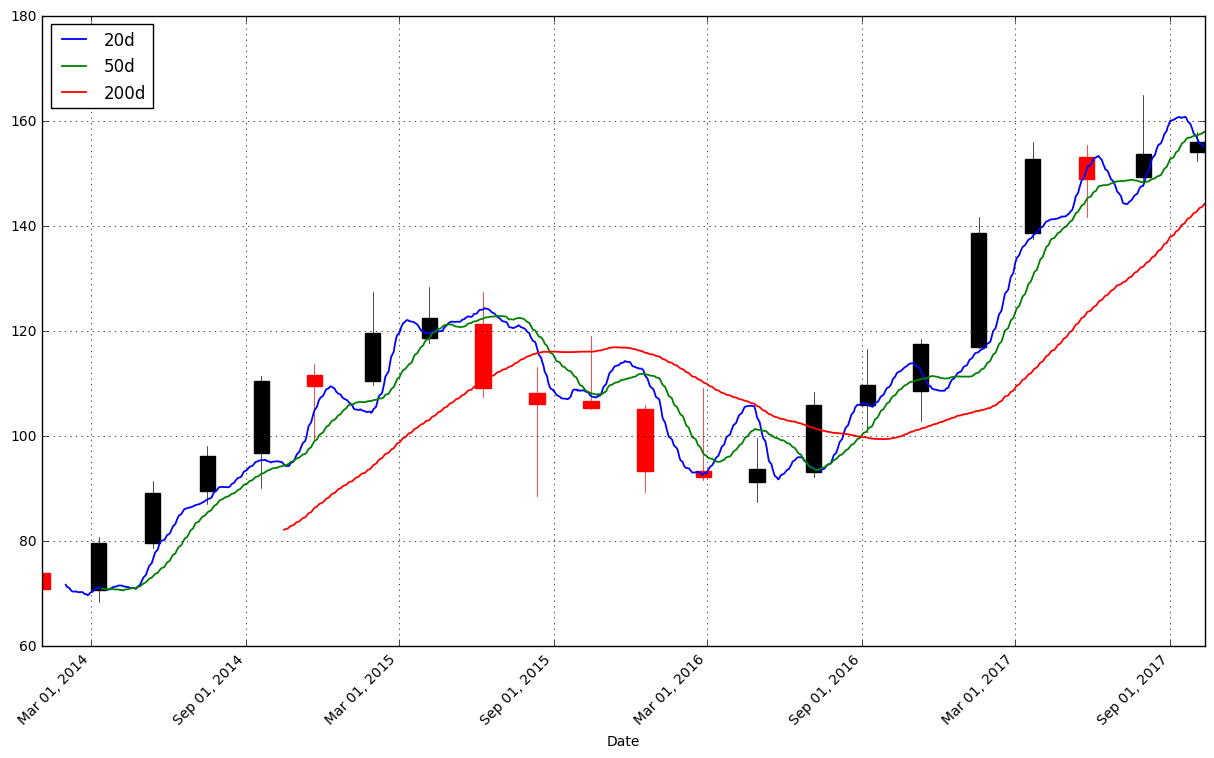

In [40]:
## Perform this parts if there is any splits, divident existsto adjust the stock price

def ohlc_adj(dat):
    """
    :param dat: pandas DataFrame with stock data, including "Open", "High", "Low", "Close", and "Adj Close", with "Adj Close" containing adjusted closing prices
 
    :return: pandas DataFrame with adjusted stock data
 
    This function adjusts stock data for splits, dividends, etc., returning a data frame with
    "Open", "High", "Low" and "Close" columns. The input DataFrame is similar to that returned
    by pandas Yahoo! Finance API.
    """
    return pd.DataFrame({"Open": dat["Open"] * dat["Adj Close"] / dat["Close"],
                       "High": dat["High"] * dat["Adj Close"] / dat["Close"],
                       "Low": dat["Low"] * dat["Adj Close"] / dat["Close"],
                       "Close": dat["Adj Close"]})
 
apple_adj = ohlc_adj(apple)
 
# This next code repeats all the earlier analysis we did on the adjusted data
 
apple_adj["20d"] = np.round(apple_adj["Close"].rolling(window = 20, center = False).mean(), 2)
apple_adj["50d"] = np.round(apple_adj["Close"].rolling(window = 50, center = False).mean(), 2)
apple_adj["200d"] = np.round(apple_adj["Close"].rolling(window = 200, center = False).mean(), 2)
 
apple_adj['20d-50d'] = apple_adj['20d'] - apple_adj['50d']
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] < 0, -1, apple_adj["Regime"])
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple_adj.ix[-1, "Regime"]
apple_adj.ix[-1, "Regime"] = 0
apple_adj["Signal"] = np.sign(apple_adj["Regime"] - apple_adj["Regime"].shift(1))
# Restore original regime data
apple_adj.ix[-1, "Regime"] = regime_orig
 
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_adj_signals = pd.concat([
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == 1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == -1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_adj_signals.sort_index(inplace = True)
apple_adj_long_profits = pd.DataFrame({
        "Price": apple_adj_signals.loc[(apple_adj_signals["Signal"] == "Buy") &
                                  apple_adj_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_adj_signals["Price"] - apple_adj_signals["Price"].shift(1)).loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_adj_signals["Price"].loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].index
    })
 
pandas_candlestick_ohlc(apple_adj, stick = 45, otherseries = ["20d", "50d", "200d"])

In [41]:
apple_adj_long_profits

,End Date,Price,Profit
Date,,,
2014-03-14,2014-03-17,70.159729,0.274132
2014-03-24,2014-04-22,72.098618,-1.001534
2014-04-25,2014-10-17,76.477829,15.910706
2014-10-28,2015-01-05,100.968079,-0.027687
2015-02-05,2015-04-16,114.395966,5.942024
2015-04-28,2015-06-25,124.525078,-2.410607
2015-10-27,2015-12-18,110.208076,-7.760406
2016-03-10,2016-05-05,98.282295,-7.152160
2016-06-23,2016-06-27,93.925415,-3.968124


In [46]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_adj_long_profits.index,
                            "End": apple_adj_long_profits["End Date"]})
apple_adj_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple_adj.loc[x["Start"]:x["End"], "Low"]), axis = 1)
apple_adj_long_profits

,End Date,Price,Profit,Low
Date,,,,
2014-03-14,2014-03-17,70.159729,0.274132,69.933752
2014-03-24,2014-04-22,72.098618,-1.001534,68.373269
2014-04-25,2014-10-17,76.477829,15.910706,75.410772
2014-10-28,2015-01-05,100.968079,-0.027687,99.653243
2015-02-05,2015-04-16,114.395966,5.942024,112.955754
2015-04-28,2015-06-25,124.525078,-2.410607,117.657874
2015-10-27,2015-12-18,110.208076,-7.760406,102.235102
2016-03-10,2016-05-05,98.282295,-7.152160,89.762635
2016-06-23,2016-06-27,93.925415,-3.968124,89.429509


## Trading Simulation

In [47]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits
cash = 1000000
apple_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .2    # % of trade loss that would trigger a stoploss
for index, row in apple_adj_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest = apple_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)
 
apple_backtest

,End Date,End Port. Value,Profit per Share,Share Price,Shares,Start Port. Value,Stop-Loss Triggered,Total Profit,Trade Value
2014-03-14,2014-03-17,1.000384e+06,0.274132,70.159729,1400.0,1.000000e+06,0.0,383.7848,98223.6206
2014-03-24,2014-04-22,9.990818e+05,-1.001534,72.098618,1300.0,1.000384e+06,0.0,-1301.9942,93728.2034
2014-04-25,2014-10-17,1.019766e+06,15.910706,76.477829,1300.0,9.990818e+05,0.0,20683.9178,99421.1777
2014-10-28,2015-01-05,1.019738e+06,-0.027687,100.968079,1000.0,1.019766e+06,0.0,-27.6870,100968.0790
2015-02-05,2015-04-16,1.024492e+06,5.942024,114.395966,800.0,1.019738e+06,0.0,4753.6192,91516.7728
2015-04-28,2015-06-25,1.022563e+06,-2.410607,124.525078,800.0,1.024492e+06,0.0,-1928.4856,99620.0624
2015-10-27,2015-12-18,1.015579e+06,-7.760406,110.208076,900.0,1.022563e+06,0.0,-6984.3654,99187.2684
2016-03-10,2016-05-05,1.008427e+06,-7.152160,98.282295,1000.0,1.015579e+06,0.0,-7152.1600,98282.2950
2016-06-23,2016-06-27,1.004459e+06,-3.968124,93.925415,1000.0,1.008427e+06,0.0,-3968.1240,93925.4150
2016-06-30,2016-07-11,1.005807e+06,1.348771,93.436729,1000.0,1.004459e+06,0.0,1348.7710,93436.7290


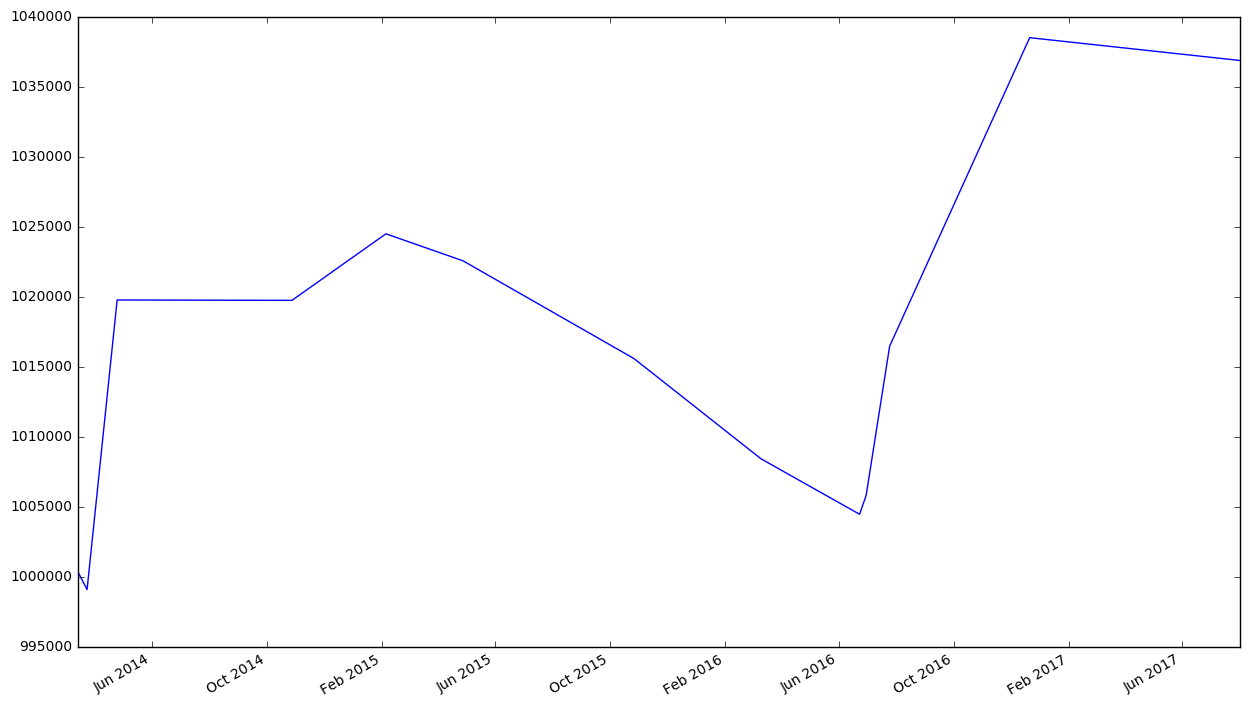

In [48]:
apple_backtest["End Port. Value"].plot()

## Trading Multiple Stocks

In [45]:
def ma_crossover_orders(stocks, fast, slow):
    """
    :param stocks: A list of tuples, the first argument in each tuple being a string containing the ticker symbol of each stock (or however you want the stock represented, so long as it's unique), and the second being a pandas DataFrame containing the stocks, with a "Close" column and indexing by date (like the data frames returned by the Yahoo! Finance API)
    :param fast: Integer for the number of days used in the fast moving average
    :param slow: Integer for the number of days used in the slow moving average
 
    :return: pandas DataFrame containing stock orders
 
    This function takes a list of stocks and determines when each stock would be bought or sold depending on a moving average crossover strategy, returning a data frame with information about when the stocks in the portfolio are bought or sold according to the strategy
    """
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str
 
    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        # Get the moving averages, both fast and slow, along with the difference in the moving averages
        s[1][fast_str] = np.round(s[1]["Close"].rolling(window = fast, center = False).mean(), 2)
        s[1][slow_str] = np.round(s[1]["Close"].rolling(window = slow, center = False).mean(), 2)
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]
 
        # np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)
        # We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])
        # To ensure that all trades close out, I temporarily change the regime of the last row to 0
        regime_orig = s[1].ix[-1, "Regime"]
        s[1].ix[-1, "Regime"] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        # Restore original regime data
        s[1].ix[-1, "Regime"] = regime_orig
 
        # Get signals
        signals = pd.concat([
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == 1, "Regime"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == -1, "Regime"],
                         "Signal": "Sell"}),
        ])
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)
 
    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])
 
    return trades
 
 
def backtest(signals, cash, port_value = .1, batch = 100):
    """
    :param signals: pandas DataFrame containing buy and sell signals with stock prices and symbols, like that returned by ma_crossover_orders
    :param cash: integer for starting cash value
    :param port_value: maximum proportion of portfolio to risk on any single trade
    :param batch: Trading batch sizes
 
    :return: pandas DataFrame with backtesting results
 
    This function backtests strategies, with the signals generated by the strategies being passed in the signals DataFrame. A fictitious portfolio is simulated and the returns generated by this portfolio are reported.
    """
 
    SYMBOL = 1 # Constant for which element in index represents symbol
    portfolio = dict()    # Will contain how many stocks are in the portfolio for a given symbol
    port_prices = dict()  # Tracks old trade prices for determining profits
    # Dataframe that will contain backtesting report
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})
 
    for index, row in signals.iterrows():
        # These first few lines are done for any trade
        shares = portfolio.setdefault(index[SYMBOL], 0)
        trade_val = 0
        batches = 0
        cash_change = row["Price"] * shares   # Shares could potentially be a positive or negative number (cash_change will be added in the end; negative shares indicate a short)
        portfolio[index[SYMBOL]] = 0  # For a given symbol, a position is effectively cleared
 
        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]
 
        if row["Signal"] == "Buy" and row["Regime"] == 1:  # Entering a long position
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
            trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
            cash_change -= trade_val  # We are buying shares so cash will go down
            portfolio[index[SYMBOL]] = batches * batch  # Recording how many shares are currently invested in the stock
            port_prices[index[SYMBOL]] = row["Price"]   # Record price
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1: # Entering a short
            pass
            # Do nothing; can we provide a method for shorting the market?
        #else:
            #raise ValueError("I don't know what to do with signal " + row["Signal"])
 
        pprofit = row["Price"] - old_price   # Compute profit per share; old_price is set in such a way that entering a position results in a profit of zero
 
        # Update report
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val,
                "Type": row["Signal"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit
            }, index = [index]))
        cash += cash_change  # Final change to cash balance
 
    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
 
    return results
 
# Get more stocks
microsoft = pdr.get_data_yahoo("MSFT", start, end)
google = pdr.get_data_yahoo("GOOG", start, end)
facebook = pdr.get_data_yahoo("FB", start, end)
twitter = pdr.get_data_yahoo("TWTR", start, end)
netflix = pdr.get_data_yahoo("NFLX", start, end)
amazon = pdr.get_data_yahoo("AMZN", start, end)
nvidia = pdr.get_data_yahoo("NVDA",  start, end)
sony = pdr.get_data_yahoo("SNY", start, end)
nintendo = pdr.get_data_yahoo("NTDOY", start, end)
ibm = pdr.get_data_yahoo("IBM", start, end)
hp = pdr.get_data_yahoo("HPQ", start, end)

signals = ma_crossover_orders([("AAPL", ohlc_adj(apple)),
                              ("MSFT",  ohlc_adj(microsoft)),
                              ("GOOG",  ohlc_adj(google)),
                              ("FB",    ohlc_adj(facebook)),
                              ("TWTR",  ohlc_adj(twitter)),
                              ("NFLX",  ohlc_adj(netflix)),
                              ("AMZN",  ohlc_adj(amazon)),
                              ("NVDA",  ohlc_adj(nvidia)),
                              ("SNY",   ohlc_adj(sony)),
                              ("NTDOY", ohlc_adj(nintendo)),
                              ("IBM",   ohlc_adj(ibm)),
                              ("HPQ",   ohlc_adj(hp))],
                            fast = 20, slow = 50)

signals

Price  Regime Signal
Date       Symbol                            
2014-03-14 AAPL      70.159729     1.0    Buy
           AMZN     373.739990    -1.0   Sell
           FB        67.720001     1.0    Buy
           GOOG     582.610657     1.0    Buy
           HPQ       11.716223     1.0    Buy
           IBM      162.227341     1.0    Buy
           MSFT      34.436348     1.0    Buy
           NFLX      60.641430     1.0    Buy
           NTDOY     14.019056    -1.0   Sell
           NVDA      17.079487     1.0    Buy
           SNY       43.119408     1.0    Buy
           TWTR      51.919998    -1.0   Sell
2014-03-17 AAPL      70.433861    -1.0   Sell
2014-03-24 AAPL      72.098618     1.0    Buy
2014-03-31 NFLX      50.290001    -1.0   Sell
2014-04-02 GOOG     563.899353    -1.0   Sell
2014-04-07 FB        56.950001    -1.0   Sell
2014-04-22 AAPL      71.097084    -1.0   Sell
2014-04-25 AAPL      76.477829     1.0    Buy
2014-05-20 IBM      165.571869    -1.0   Sell
2014-05-22 NVDA      17.639582    -1.0   Sell
2014-05-28 MSFT      36.804203    -1.0   Sell
2014-05-29 NFLX      59.314285     1.0    Buy
2014-06-02 MSFT      37.521706     1.0    Buy
           NVDA      18.236557     0.0    Buy
2014-06-03 FB        62.869999     1.0    Buy
           NVDA      18.159529     1.0    Buy
2014-06-04 NTDOY     14.092369     1.0    Buy
2014-06-05 GOOG     550.871033     1.0    Buy
2014-06-13 AMZN     326.269989     1.0    Buy
...                        ...     ...    ...
2017-06-30 NFLX     149.410004    -1.0   Sell
2017-07-03 IBM      153.953400     1.0    Buy
2017-07-07 GOOG     918.590027    -1.0   Sell
           SNY       47.900002    -1.0   Sell
2017-07-17 TWTR      19.940001     1.0    Buy
2017-07-21 NFLX     188.539993     1.0    Buy
2017-07-24 IBM      144.463654    -1.0   Sell
2017-07-26 HPQ       19.127413     0.0    Buy
2017-07-27 HPQ       19.077757     1.0    Buy
2017-08-02 AAPL     156.525330     1.0    Buy
2017-08-11 TWTR      15.920000    -1.0   Sell
2017-08-21 AMZN     953.289978    -1.0   Sell
2017-08-30 SNY       48.189999     1.0    Buy
2017-09-22 IBM      145.130005     1.0    Buy
           TWTR      17.610001     0.0    Buy
2017-09-25 TWTR      16.980000     1.0    Buy
2017-09-28 GOOG     949.500000     1.0    Buy
2017-10-02 AAPL     153.809998    -1.0   Sell
2017-10-12 AAPL     156.000000    -1.0    Buy
           AMZN    1000.929993    -1.0    Buy
           FB       172.550003     1.0   Sell
           GOOG     987.830017     1.0   Sell
           HPQ       20.400000     1.0   Sell
           IBM      147.029999     1.0   Sell
           MSFT      77.120003     1.0   Sell
           NFLX     195.860001     1.0   Sell
           NTDOY     48.320000     1.0   Sell
           NVDA     191.029999     1.0   Sell
           SNY       49.740002     1.0   Sell
           TWTR      18.450001     1.0   Sell

[273 rows x 3 columns]

Reference:
* [An Introduction to Stock Market Data Analysis with Python](https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/)